# Логистическая регрессия и случайный лес, домашнее задание

## Обзор

В задании вам предстоит на простом примере познакомиться с базовыми инструментами построения логистической регрессии:
* визуализация
* разбиение данных на обучающую и тестовую выборки
* преобразование переменных
* отбор переменных
* $L1$ и $L2$ регуляризации
* построение итоговой модели и валидация

Далее вы построите случайный лес и сравните два класса моделей.

Все это будет на сгенерированных данных.
Примеры многих функций уже есть в коде, остальное можно посмотреть в официальных документациях или просто поискать в интернете примеры применения.

Оценка будет выставляться с учетом первых трех заданий, третье опционально

## Сгенерируем данные

In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X, y = make_classification(n_samples=7000, n_features=20, n_informative=5, n_redundant=2,
                           n_repeated=0, scale=None, shift=None, shuffle=False, class_sep=0.5, 
                           random_state=40)

Разбивка на train и test нужна для того, чтобы оставить часть данных нетронутой для проверки

Модель мы будем применять на данных, которые еще не видели, и разбивка позволяет нам хоть немного имитировать этот процесс

Если хотим использовать методы, требующие ручного подбора параметров (например, коэффициента регуляризации), можно выделить еще третий вид выборки — валидационную или validation. Подбор параметров традиционно выглядит так:
1. задаем параметр;
2. обучаем модель на train;
3. смотрим на качество предсказания на validation;
4. снова задаем параметр, возвращаемся к п.2;
5. ищем максимум качества на валидации;
6. выбираем параметры, которые лучше всего себя показали на validation, обучаем еще раз модель, проверяем итоги на test.

Если ручных параметров нет, можно делить выборку на 2 части — train, test

Выборка бьется последовательным применением train_test_split

Стандартные пропорции: 70:30 в случае с train/test, 60:20:20 в случае с train/val/test

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Можно визуализировать зависимости, посмотреть на характер данных

In [ ]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.show()

Первично анализировать признаки удобно с помощью woe_line.

Функция делит наблюдения на группы по $X$, для каждой группы считает WoE, и откладывает эти значения на графике.

Можно встретить определение WoE, отличающееся знаком, на анализ и выводы это не влияет

# Анализ данных

## Подготовка

## Задание 1

Написать функцию woe_line:

1. разбить наблюдения на n_buckets групп по $X$
2. в каждой группе по y отложить WoE, по x медианное значение $X$
3. вывести полученный график
4. вывести ROC AUC признака (sklearn.metrics.roc_auc_score)
5. Опционально. Рассчитать доверительный интервал для bad rate (bad rate - доля наблюдений с целевой переменной =1 от всех наблюдений в группе)
6. Опционально. Нанести на график линейное приближение любым способом

График позволит проверить линейность зависимости, силу переменной, опционально проверить распределение

In [ ]:
def woe_line(X,         # 1-d array with independent feature 
             y,         # 1-d array with target feature
             n_buckets, # number of buckets to plot
             var_nm,    # optional, var_name to show above the plot
             target_nm, # optional, target_name to show above the plot
             plot_hist  # optional, if True — histogram of X is displayed
            ):
    # your code here

На примере функция дополнительно отображает $R^2$ — меру линейности зависимости, а также линию, показывающую линейное приближение

## Анализ каждой переменной

В ячейке ниже пример функции и результата ее выполнения на других данных. Сам график может быть отрисован чуть иначе или в другой библиотеке, главное — сохранить суть

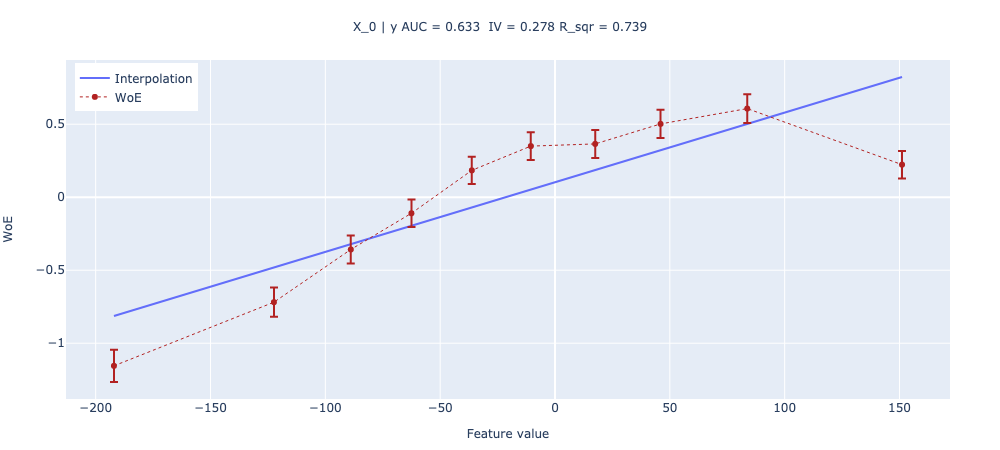

In [3]:
res = woe_line(X_train[:, 0], y_train, n_buckets=10, plot_hist=False, 
               var_nm = 'X_0', target_nm = 'y')

Видно, что переменная разделяет целевую переменную примерно до значения 0, дальше кривая выходит на плато. Можно ограничить этот хвост, чтобы не закладывать разделение в модель

Можно сразу в woe_line передавать преобразованную переменную, важно потом при проверках модели на test не забыть сделать то же преобразование

Для борьбы с выбросами можно также ограничивать длинные хвосты распределения. Особенно это полезно в реальном применении модели, чтобы ограничить влияние одной переменной на предсказание всей модели

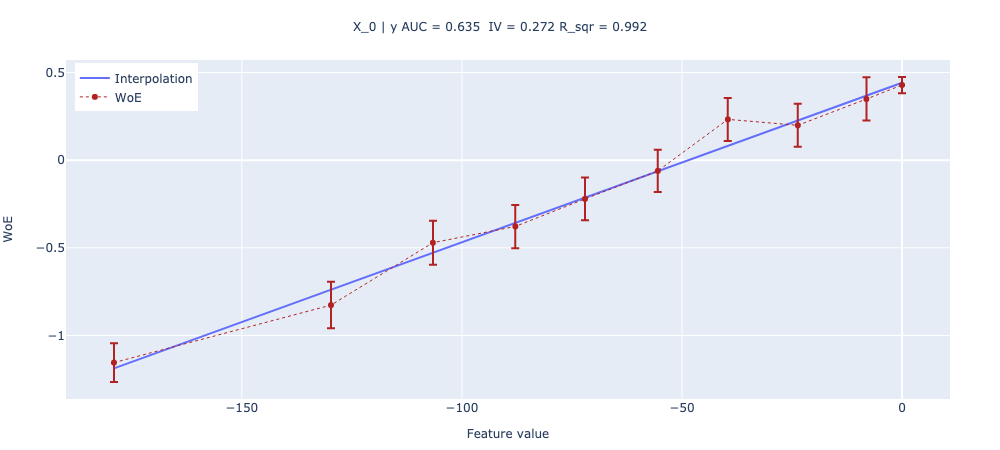

In [4]:
res = woe_line(np.clip(X_train[:, 0], -200, 0), y_train, n_buckets=10, plot_hist=False, 
               var_nm = 'X_0', target_nm = 'y')

При преобразовании переменных важно соблюдать баланс:

1. переменная должна стать линейной,
2. не стоит доводить до идеальной линейности в ущерб разделяющей силы (ROC AUC),
3. в работе с реальными данными стоит обращать внимание на физический смысл переменных. Например, в случае с размерными переменными (рубли, метры), часто помогает взятие корня или логарифма, а еще лучше приводить их к безразмерным величинам нормировкой.

## Задание 2

1. проверить каждую переменную на woe_line,
2. каждую полезную переменную линеаризовать (для каждой переменной нужны графики ДО и ПОСЛЕ),
3. ненужные переменные (слабые по ROC AUC, немонотонные) исключить из модели,
4. на отобранных и линеаризованных переменных построить модель, проверить результат на test по ROC AUC.

Подробно про обучение моделей можно почитать в официальной документации, там же есть примеры использования

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

# Построение логистической регрессии

In [7]:
# your code here

## Задание 3

В этом задании предлагается сравнить алгоритм Random Forest с логистической регрессией. Обучите две модели, подобрав гиперпараметры на отделенной от трейна валидационной выборке.

 - на всех признаках из изначального датасета (на сырых данных)
 - на признаках, на которых вы строили логрег (после удаления неинформативных признаков и линеаризации остальных)

Насколько сильнее (или наоборот слабее) показали себя "деревянные модели" по сравнению с линейными? Помогла ли предобработка переменных улучшить качество случайного леса?

# Построение случайного леса

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# your code here

# Дополнительно

Задание 4, опционально

В функции генерации датасета указано $n\_redundant=2$. Это значит, что две переменные получены линейной комбинацией информативных переменных.

Предыдущий анализ никак не исключает появления всех переменных в модели, для этого можно воспользоваться методами отбора признаков.

1. нужно разбить исходную выборку на 3 части: train, val, test, и попробовать подобрать коэффициент $L1$-регуляризации на валидационной выборке. Это должно убрать лишние переменные из модели и повысить таким образом ее стабильность.

Регуляризации в логистической регрессии сильно зависит от стандартного отклонения признака, поэтому стоит воспользоваться нормировкой: sklearn.preprocessing.StandardScaler

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

С нормировкой действуют те же правила: обучается она на train, применяется на val, test

2. подобрать коэффициент $L2$-регуляризации, чтобы избежать слишком больших коэффициентов и улучшить качество на val, test. На этом шаге использовать только те переменные, которые отобраны после п.1

In [ ]:
# your code here